# 2D Image Progressive Refinement Demo with Linear Bregman Iteration



by Xingjia Wang

Summary: The following notebook contains a demonstration of using Linear Bregman Iteration to recover progressively a random 2D image (represented by a 2D numpy array) with binned regional recovery, i.e., the recovery process will only be applied on selected non-zero regions of the blurred image. 

## Unit Import

In [1]:
import numpy as np
import scipy.ndimage
import scipy.ndimage.filters as fi
import scipy.stats as st
import matplotlib.pyplot as plt

In [2]:
from linBreg import *

## Used Functions 

### Data Generating Functions

- gkern(kernlen=21, nsig=3): returns a 2D Gaussian Kernel
- applyK(K, n, loc=0, binsize=1): returns a sensing matrix with selected kernel

In [3]:
def gkern(kernlen=21, nsig=3):
    '''
    *
    * @param <int>kernlen = 21, <int>nsig = 3
    * @retur <2darray>kernel - 2D Gaussian kernel with sigma = nsig
    *
    '''
    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

In [4]:
'''
********* Cross-shaped Kernel Generation ********* 

type: function
return: 3d numpy array
'''

# Generating a 3d cross-shaped kernel
def kern2d_cross (klen):
    K1 = np.zeros((klen, klen))
    half = klen//2
    K1[half,half] = 0.6
    K1[half+1,half] = 0.1
    K1[half,half+1] = 0.1
    K1[half,half-1] = 0.1
    K1[half-1,half] = 0.1
    return K1;
    

In [5]:
def applyK(K, n, loc = 0, binsize = 1):
    
    '''
    *
    * @param <2darray>K, <int>n, <int/2darray>loc, <int> 1
    * @retur <2darray>A - Sensing matrix
    *
    * Applies kernel K onto each pixel of an empty matrix that is of the same size as the ground truth 
    *
    '''
    
    
    # loc = 0 or np.array((len, 2))
    
    if (type(loc) == int):
        A = np.zeros((pow(n//binsize,2), pow(n,2)))
        kernal_half_width = len(K)//2
        for xind in np.arange(0,n):
            for yind in np.arange(0,n):
                im = np.zeros((n,n))
                Ind = xind*n + yind
                im_x1 = np.max([xind - kernal_half_width, 0])
                im_x2 = np.min([xind + kernal_half_width, n])
                im_y1 = np.max([yind - kernal_half_width, 0])
                im_y2 = np.min([yind + kernal_half_width, n])

                k_x1 = kernal_half_width + 1 - (xind - im_x1)
                k_x2 = kernal_half_width + 1 + (im_x2 - xind)
                k_y1 = kernal_half_width + 1 - (yind - im_y1)
                k_y2 = kernal_half_width + 1 + (im_y2 - yind)

                im[im_x1:im_x2, im_y1:im_y2] = K[k_x1:k_x2, k_y1:k_y2]
                A[:,Ind]=binPixel(np.reshape(im, (n,n)), binsize).ravel()
    else:
        A = np.zeros((pow(n//binsize,2), len(loc)))  
        kernal_half_width = len(K)//2
        Ind = 0
        for idx in loc:
            xind = idx[0]
            yind = idx[1]
            im = np.zeros((n,n))
            im_x1 = np.max([xind - kernal_half_width, 0])
            im_x2 = np.min([xind + kernal_half_width, n])
            im_y1 = np.max([yind - kernal_half_width, 0])
            im_y2 = np.min([yind + kernal_half_width, n])
            
            k_x1 = kernal_half_width + 1 - (xind - im_x1)
            k_x2 = kernal_half_width + 1 + (im_x2 - xind)
            k_y1 = kernal_half_width + 1 - (yind - im_y1)
            k_y2 = kernal_half_width + 1 + (im_y2 - yind)
            

            im[im_x1:im_x2, im_y1:im_y2] = K[k_x1:k_x2, k_y1:k_y2]
            A[:,Ind]=binPixel(np.reshape(im, (n,n)), binsize).ravel()
            Ind += 1
    return A

### Regional Recovering Functions

- region_select(blur, crit=1e-3): returns locations to be recovered
- region_to_full(u, loc): convert regional recovery to full recovery 

In [6]:
def region_select(blur, crit = 1e-3):
    '''
    *
    * @param <ndarray>blur, <double>crit = 1e-3
    * @retur <2darray>loc - locations of values in blur that are greater than the criterion value
    *
    '''
    loc = np.where(blur > crit)
    loc = np.transpose(loc)
    
    return loc

In [7]:
def region_to_full(u, loc, n):
    '''
    *
    * @param <2darray>u - regional recovery results, <2darray>loc - location from selected recovery region
    * @retur <2darray>rec - full recovery result
    *
    '''
    rec = np.zeros((n,n))
    loc = np.transpose(loc)
    for num in np.arange(0, len(loc[0, :])):
        i = loc[0, num]
        j = loc[1, num]
        rec[i][j] = u[num]
    
#     rec = rec[rec[:,1].argsort()]
#     rec = rec[rec[:,0].argsort(kind='mergesort')]
        
    return rec

### Binning Functions

- binPixel(p, ind): returns a binned matrix
- loc_convert(loc, binsize=1): converts locations from binned matrix to those of the unbinned

In [8]:
def binPixel(p, ind):
    
    '''
    *
    * @param <2darray>p, <int>ind
    * @retur <2darray>a1 - bins 2d array p by ind*ind pixels
    *
    '''
    
    x = p.shape[0]
    y = p.shape[1]
    a1 = p.reshape((x*y//ind,ind)).sum(1).reshape(x,y//ind).transpose().reshape(x*y//ind//ind,ind).sum(1).reshape(y//ind,x//ind).transpose()
    return a1

In [9]:
def loc_convert(loc, globin, binsize = 1):
    '''
    *
    * @param <2darray>loc, <int>globin, <int>binsize = 1
    * @retur <2darray>glob_loc - converts the binned location to the corresponding unbinned location
    *
    '''
    glob_loc = np.zeros(((binsize**2)*len(loc),2))
    bin_half_width = binsize // 2
    loc = loc * binsize
    loc = loc + bin_half_width
    ind = 0
    factor = globin // binsize
    for grid in loc:
        xloc = grid[0] - bin_half_width
        yloc = grid[1] - bin_half_width
        for xind in np.arange(0,binsize):
            for yind in np.arange(0,binsize):
                glob_loc[ind][0] = factor*(xloc + xind)
                glob_loc[ind][1] = factor*(yloc + yind)
                ind += 1

    glob_loc = glob_loc.astype(int)
    return glob_loc

### Refinement Functions

- refine:

In [10]:
def refine(blur, kernel, loc, bsize, csize, rsize):
    scalar = csize // rsize
    n = blur.shape[0] * bsize
    
    # Map binned location to global location
    loc = loc_convert(loc, csize, rsize)
    # Generating regional sensing matrix with binning
    A_bin = applyK(kernel, n, loc, bsize)
    # Regional recovery iteration
    u_bin = linbreg(blur.ravel(), A_bin, threshold = 1e8, stepsize = 2e-10, maxstep = 6e4, crit = 1e-7, plot = False)
    # Regional recovery to full recovery finish-up
    rec = region_to_full(u_bin, loc//scalar, n//scalar)
    return rec

## Simulation Run

### Data Initialization

In [21]:
n = 100
binsize = 10

In [22]:
# Generating a Gaussian kernel K
K = gkern(n+1, 10)

# Generating a n*n ground truth
imTest = np.zeros((n,n))
midpoint = int(np.ceil(n/4))
idx = np.random.randint(0,n-1,midpoint)
for i in idx:
    imTest[i][np.random.randint(0,n-1)] = np.random.rand()
    
# Generating a sensing matrix
A = applyK(K, n)

# Generating the blur from sensing matrix
l = np.matmul(A, imTest.ravel())
blur = l.reshape((n,n))

### Regional Recovery with Binning

10000
20000
30000
40000
50000


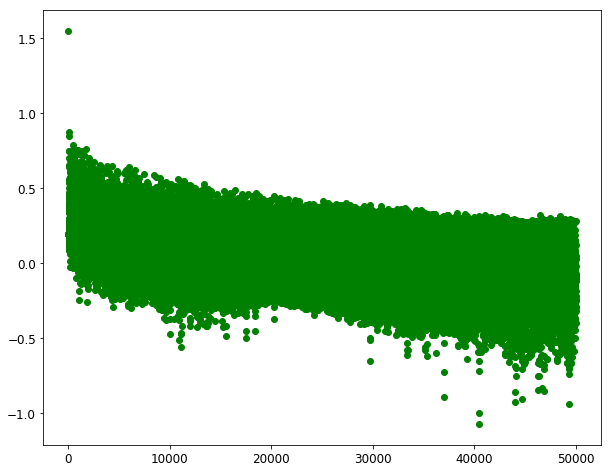

In [23]:
# Binning the blur
blur_bin = binPixel(blur,binsize)

# Recovery region selection
binned_loc = region_select(blur_bin)

# Map binned location to global location
rec_loc = loc_convert(binned_loc, binsize, binsize)

# Generating regional sensing matrix with binning
A_bin = applyK(K, n, loc = rec_loc, binsize = binsize)

# Regional recovery iteration
u_regional_bin = linbreg(blur_bin.ravel(), A_bin, threshold = 1e9, stepsize = 3e-10, maxstep = 5e4, crit = 1e-7, plot = False)

# Regional recovery to full recovery finish-up

rec_bin = region_to_full(u_regional_bin, rec_loc, n)

### Progressive Refinement

10000
20000
30000
40000
50000
60000


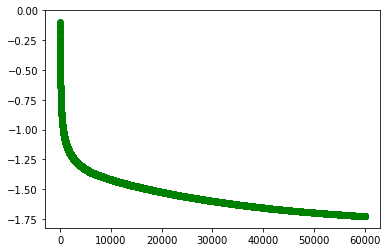

In [16]:
current_bin = binsize

'''
First Refinement: Size = fsize
'''

fsize = 2

# Recovery region selection
f_binned_loc = region_select(blur_bin)

f_rec = refine(blur_bin, K, f_binned_loc, binsize, current_bin, fsize)

current_bin = current_bin // fsize

10000
20000
30000
40000
50000
60000


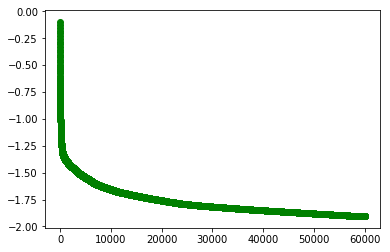

In [17]:
'''
Second Refinement: Size = 2
'''
ssize = 2

# Recovery region selection
s_binned_loc = region_select(f_rec)

s_rec = refine(blur_bin, K, s_binned_loc, binsize, current_bin, ssize)

current_bin = current_bin // ssize

## Results Visualization

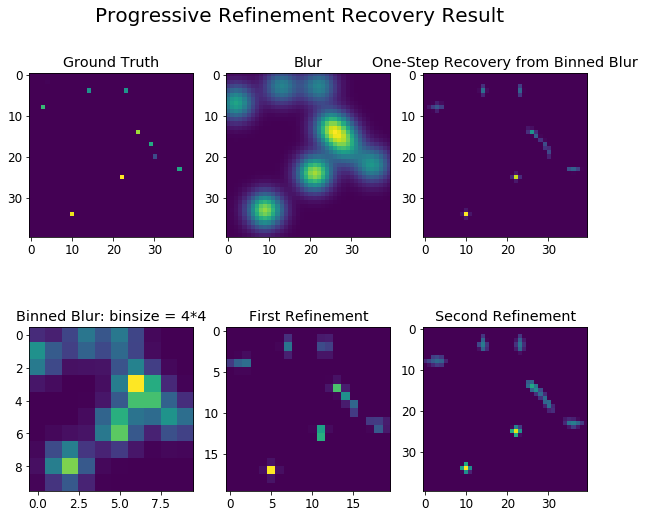

In [20]:
font = {'family' : 'DejaVu Sans',
  'size' : 12}
plt.rc('font', **font)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8

ax0 = plt.subplot(231)
ax0.get_xaxis().set_label_position('bottom')
ax0.set_title("Ground Truth")
ax0.imshow(imTest)

ax1 = plt.subplot(232)
ax1.set_title("Blur")
ax1.imshow(blur)

ax2 = plt.subplot(233)
ax2.set_title("One-Step Recovery from Binned Blur")
ax2.imshow(rec_bin)

ax3 = plt.subplot(234)
ax3.set_title("Binned Blur: binsize = 4*4")
ax3.imshow(blur_bin)

ax4 = plt.subplot(235)
ax4.set_title("First Refinement")
ax4.imshow(f_rec)
    
ax5 = plt.subplot(236)
ax5.set_title("Second Refinement")
ax5.imshow(s_rec)

    
plt.subplots_adjust(hspace=.4) 

plt.suptitle("Progressive Refinement Recovery Result", size = 20)
plt.savefig("R_4_NSig_2_40x40.jpg")